In [1]:
# 1. 데이터 전처리 관련 모듈 import
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# 2. 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_val_predict, cross_validate, StratifiedKFold

# 3. 사용할 알고리즘 import
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 4. 성능 평가
from sklearn.metrics import r2_score, root_mean_squared_error, root_mean_squared_log_error, mean_absolute_percentage_error

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pickle
import shap
import datetime as dt
import joblib

def getScore(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    # rmsle = root_mean_squared_log_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{name}, r2: {r2:.3f}, mape: {mape:.3f}, rmse: {rmse:.3f}')

c:\anaconda3\envs\gsenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# 33차(최종) 모델에 사용된 df에서 multicollinearity 높은 변수 제거함 (38차 df)
df = pd.read_csv('./df_38thtrial.csv', index_col = 'Datetime')

In [12]:
x = df.drop('SHFT_avg', axis=1)
y = df['SHFT_avg']

# # standard scaling - 최초 1회 수행
# scaler = StandardScaler()
# x_scaled = pd.DataFrame(scaler.fit_transform(x))
# x_scaled.columns = x.columns

# # pca - 최초 1회 수행
# pca = PCA(n_components=1)  # Keep one principal component
# x_pca = pca.fit_transform(x_scaled[['Ni ppm', 'V ppm']])
# x_scaled['Ni_V_PCA'] = x_pca
# x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
# print(x_train.shape, x_val.shape, x_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# best models
rf = RandomForestRegressor(n_estimators=300, max_depth=25, min_samples_leaf=2, random_state=0)
xgb = XGBRegressor(reg_alpha=0.1, reg_lambda=1, learning_rate=0.05, n_estimators = 200, max_depth=None, subsample=0.8, random_state=0)

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_rf = cross_val_score(rf, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("RF Cross-Validation Scores:", scores_rf)
print("RF CV Average Score:", scores_rf.mean())
scores_xgb = cross_val_score(xgb, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("XGB Cross-Validation Scores:", scores_xgb)
print("XGB CV Average Score:", scores_xgb.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
rf.fit(x_train, y_train)
xgb.fit(x_train, y_train)
y_val_pred_rf = rf.predict(x_val)
y_val_pred_xgb = xgb.predict(x_val)
getScore('rf_validation', y_val, y_val_pred_rf)
getScore('xgb_validation', y_val, y_val_pred_xgb)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
rf.fit(x_train_val, y_train_val)
xgb.fit(x_train_val, y_train_val)
y_test_pred_rf = rf.predict(x_test)
y_test_pred_xgb = xgb.predict(x_test)
getScore('rf_test', y_test, y_test_pred_rf)
getScore('xgb_test', y_test, y_test_pred_xgb)

RF Cross-Validation Scores: [0.81391928 0.75882883 0.71599549 0.61864317 0.81036762 0.67477297
 0.83661291 0.73654401 0.52630935 0.71794932]
RF CV Average Score: 0.7209942948620875
XGB Cross-Validation Scores: [0.79877406 0.75566809 0.70386275 0.56658128 0.7817012  0.70319934
 0.82867214 0.72768373 0.5103501  0.75996113]
XGB CV Average Score: 0.7136453823010698
rf_validation, r2: 0.689, mape: 0.129, rmse: 0.010
xgb_validation, r2: 0.697, mape: 0.133, rmse: 0.010
rf_test, r2: 0.794, mape: 0.125, rmse: 0.009
xgb_test, r2: 0.761, mape: 0.132, rmse: 0.009


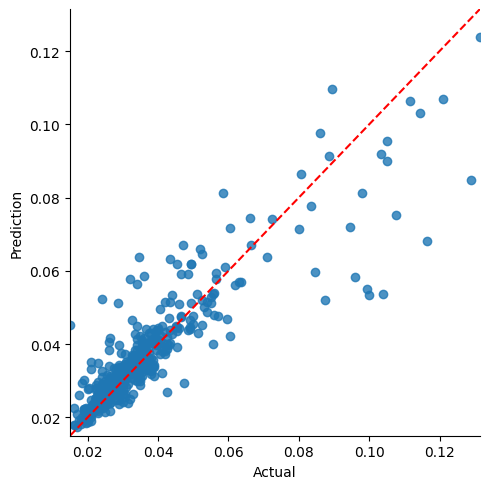

In [13]:
result_test_rf = {'Actual':y_test, 'Prediction': y_test_pred_rf}
y_plot_test_rf = pd.DataFrame(result_test_rf)
sns.lmplot(data=y_plot_test_rf, x='Actual', y='Prediction', fit_reg=False)  
lims = [min(y_test.min(), y_test_pred_rf.min()), max(y_test.max(), y_test_pred_rf.max())]  # Limits for the line
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

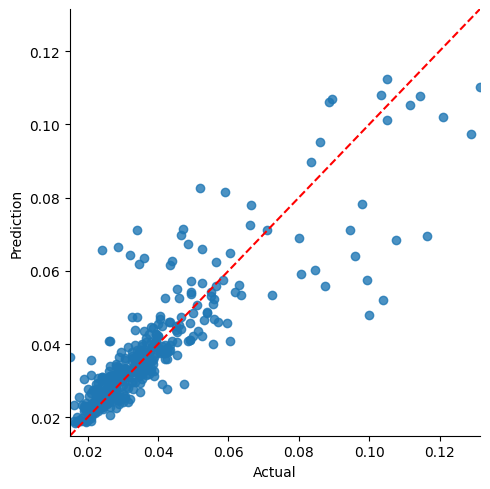

In [14]:
result_test_xgb = {'Actual':y_test, 'Prediction': y_test_pred_xgb}
y_plot_test_xgb = pd.DataFrame(result_test_xgb)
sns.lmplot(data=y_plot_test_xgb, x='Actual', y='Prediction', fit_reg=False)  
lims = [min(y_test.min(), y_test_pred_xgb.min()), max(y_test.max(), y_test_pred_xgb.max())]  # Limits for the line
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.savefig("pre_act.png")
plt.show()

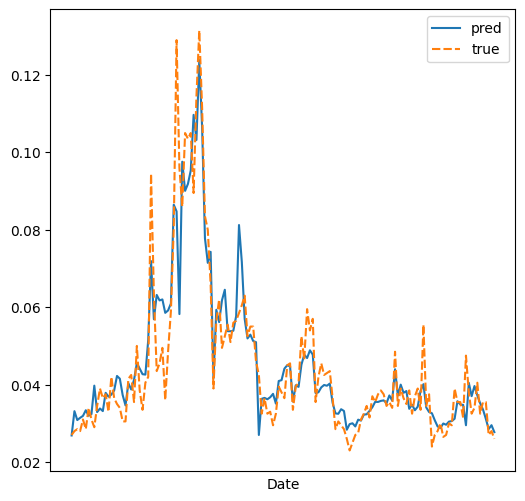

In [15]:
pred_actual_df_rf = pd.DataFrame({'pred': y_test_pred_rf, 'true':y_test})
plt.figure(figsize=(6, 6))
sns.lineplot(pred_actual_df_rf.sort_index().iloc[196:346,:])
plt.xticks([])
plt.xlabel('Date')

plt.show()

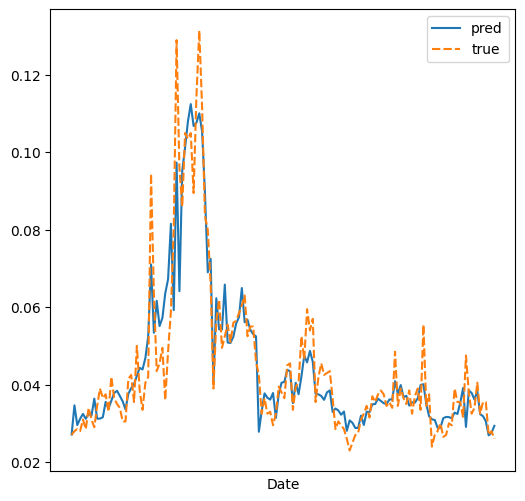

In [16]:
pred_actual_df_xgb = pd.DataFrame({'pred': y_test_pred_xgb, 'true':y_test})
plt.figure(figsize=(6, 6))
sns.lineplot(pred_actual_df_xgb.sort_index().iloc[196:346,:])
plt.xticks([])
plt.xlabel('Date')

plt.savefig("pre_act_trend.png")
plt.show()

In [17]:
# 이후 실제 데이터에 대해서는 아래 pkl 파일을 이용하여 prediction 수행
joblib.dump(rf, 'rf.pkl')
joblib.dump(xgb, 'xgb.pkl')

['xgb.pkl']